# Binary Classification with Neural Networks

- Name: Sadbhav Adhikari
- Roll number: ACE079BCT054

This assignment focuses on training a multitude of neural networks via PyTorch in order to create a classification model to determine whether a given point is within a particular region or not.

Firstly, import Pytorch and set it up with a random seed.

In [1]:
import torch

torch.manual_seed(42)

Now, import the dataset.

In [2]:
import pandas as pd

df = pd.read_csv("circles_binary_classification.csv")

df.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


We can have a quick look at it via `describe()`.

In [3]:
df.describe()

,X1,X2,label
count,1000.000000,1000.000000,1000.00000
mean,-0.000448,-0.000804,0.50000
std,0.639837,0.641156,0.50025
min,-1.059502,-1.067768,0.00000
25%,-0.619251,-0.612176,0.00000
50%,0.008762,-0.003949,0.50000
75%,0.621933,0.624822,1.00000
max,1.033712,1.036004,1.00000


The set appears fairly normal. We can now move on to setting up the features `X` and the label `y`.

In [4]:
X = df[["X1", "X2"]].values
y = df["label"].values

# Convert to tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

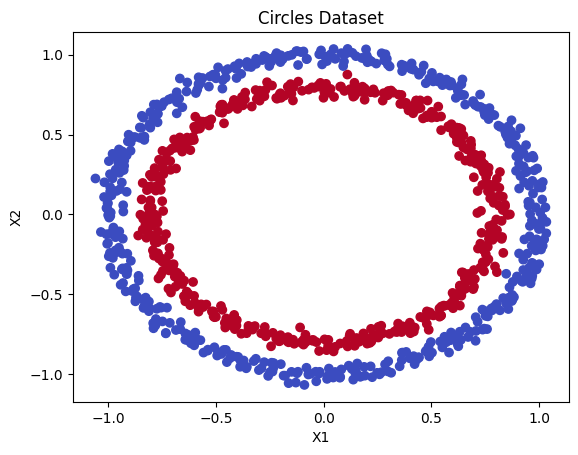

In [5]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm")
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Circles Dataset")
plt.show()

Plotting the information, we see that `X1` and `X2` each is a list of points that are within a certain boundary and outside of that boundary respectively. The task of our neural net will be to determine whether a given point is within that boundary or outside of it; therefore we are training it to recognize where that boundary is.

Now set up the train test split.

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Convert back to tensors as sklearn returns numpy
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

/tmp/ipython-input-4029850171.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
/tmp/ipython-input-4029850171.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)
/tmp/ipython-input-4029850171.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)
/tmp/ipython-input-4029850171.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or

Make the code device-agnostic, so that it uses CUDA if it's present but runs fine on the CPU if not.

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [8]:
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

Some setup before defining the models themselves, to define the loss, accuracy, optimizer and training loop.

In [9]:
import torch.nn as nn

loss_fn = nn.BCEWithLogitsLoss()

def accuracy_fn(y_true, y_logits):
  y_pred = torch.round(torch.sigmoid(y_logits))
  correct = (y_pred.squeeze() == y_true).sum().item()
  return correct / len(y_true)

For the optimizer, that is, the algorithm that determines the manner in which the model is trained, we will be using the simple stochastic gradient descent (SGD) algorithm.

SGD works by stepping the weight towards the direction with the largest gradient. The larger the gradient, the larger the step.

In [10]:
def train_and_test(model, epochs=100):
  model.to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

  train_losses = []
  test_losses = []

  for epoch in range(epochs):
    model.train()
    y_logits = model(X_train).squeeze()
    loss = loss_fn(y_logits, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
      test_logits = model(X_test).squeeze()
      test_loss = loss_fn(test_logits, y_test)

    train_losses.append(loss.item())
    test_losses.append(test_loss.item())

    if epoch % 10 == 0:
      train_acc = accuracy_fn(y_train, y_logits)
      test_acc = accuracy_fn(y_test, test_logits)
      print(f"epoch {epoch} | train loss: {loss:.4f} | test loss: {test_loss:.4f} | train acc: {train_acc:.4f} | test acc: {test_acc:.4f}")

  return train_losses, test_losses

These functions will be essential for the overall workflow of training the neural networks.

Additionally, we will use a decision boundary plotter, which will be of tremendous help in visualizing our results.

In [11]:
import numpy as np

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

## Model V0 (2 -> 5 -> 1, no activation)

The first model `V0` is an extremely simple network, which only has a single hidden layer, with only 5 neurons. It does not use any activation function between the layers.

In [12]:
class ModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(2, 5)
    self.layer2 = nn.Linear(5, 1)

  def forward(self, x):
    return self.layer2(self.layer1(x))

We will now train this network for a hundred epochs, which should be enough for something of this level of simplicity.

In [13]:
model_v0 = ModelV0()
losses_v0 = train_and_test(model_v0, epochs=100)

epoch 0 | train loss: 0.6957 | test loss: 0.6972 | train acc: 0.5000 | test acc: 0.5000
epoch 10 | train loss: 0.6940 | test loss: 0.6962 | train acc: 0.5000 | test acc: 0.5000
epoch 20 | train loss: 0.6934 | test loss: 0.6959 | train acc: 0.4600 | test acc: 0.4850
epoch 30 | train loss: 0.6932 | test loss: 0.6958 | train acc: 0.4900 | test acc: 0.4750
epoch 40 | train loss: 0.6931 | test loss: 0.6957 | train acc: 0.4950 | test acc: 0.4650
epoch 50 | train loss: 0.6931 | test loss: 0.6957 | train acc: 0.5038 | test acc: 0.4650
epoch 60 | train loss: 0.6931 | test loss: 0.6956 | train acc: 0.5050 | test acc: 0.4650
epoch 70 | train loss: 0.6930 | test loss: 0.6956 | train acc: 0.5050 | test acc: 0.4650
epoch 80 | train loss: 0.6930 | test loss: 0.6955 | train acc: 0.5075 | test acc: 0.4650
epoch 90 | train loss: 0.6930 | test loss: 0.6955 | train acc: 0.5038 | test acc: 0.4650


Visibly, the loss levels have barely decreased, and the accuracy has similarly barely increased; in fact the test accuracy has decreased. To observe this more clearly we can visualize the results.

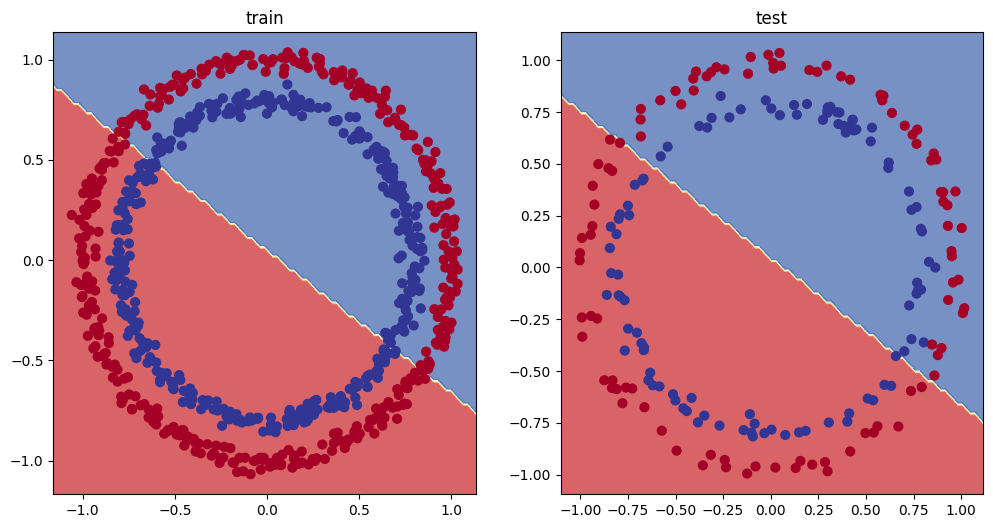

In [14]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("train")
plot_decision_boundary(model_v0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("test")
plot_decision_boundary(model_v0, X_test, y_test)

Looking at the decision boundary it is clear that the network has no clue what it is doing; the result is not much better than randomly guessing which point is within or outside the actual boundary.

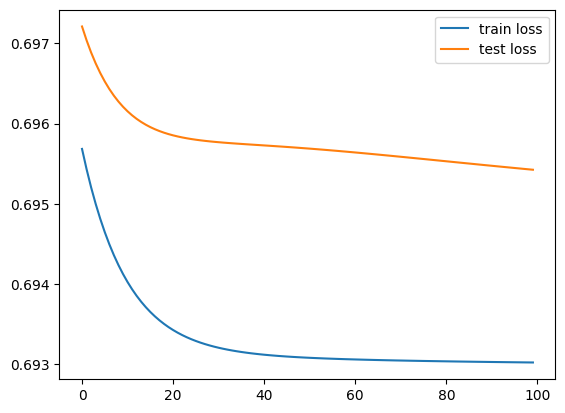

In [15]:
plt.plot(losses_v0[0], label="train loss")
plt.plot(losses_v0[1], label="test loss")
plt.legend()
plt.show()

As visible above, the losses have barely decreased as well; simply reaching and then hanging around the value of $ln(2)$. Will increasing the number of layers and neurons help make this better?

## Model V1 (2 -> 15 -> 15 -> 1, no activation)

The second network, `V1`, is essentially a beefed-up version of `V0` which has an extra hidden layer, and each hidden layer now has 15 neurons instead of 5.

In [16]:
class ModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(2, 15)
    self.layer2 = nn.Linear(15, 15)
    self.layer3 = nn.Linear(15, 1)

  def forward(self, x):
    return self.layer3(self.layer2(self.layer1(x)))

Now we will be training it, this time for a thousand epochs to account for the increased complexity.

In [17]:
model_v1 = ModelV1()
losses_v1 = train_and_test(model_v1, epochs=1000)

epoch 0 | train loss: 0.6942 | test loss: 0.6937 | train acc: 0.5025 | test acc: 0.5650
epoch 10 | train loss: 0.6938 | test loss: 0.6934 | train acc: 0.5000 | test acc: 0.5150
epoch 20 | train loss: 0.6935 | test loss: 0.6934 | train acc: 0.4988 | test acc: 0.5250
epoch 30 | train loss: 0.6934 | test loss: 0.6935 | train acc: 0.4950 | test acc: 0.5350
epoch 40 | train loss: 0.6932 | test loss: 0.6936 | train acc: 0.4963 | test acc: 0.5250
epoch 50 | train loss: 0.6932 | test loss: 0.6937 | train acc: 0.4938 | test acc: 0.5100
epoch 60 | train loss: 0.6931 | test loss: 0.6938 | train acc: 0.5025 | test acc: 0.5150
epoch 70 | train loss: 0.6931 | test loss: 0.6939 | train acc: 0.5050 | test acc: 0.4950
epoch 80 | train loss: 0.6930 | test loss: 0.6940 | train acc: 0.5025 | test acc: 0.4750
epoch 90 | train loss: 0.6930 | test loss: 0.6941 | train acc: 0.5050 | test acc: 0.4700
epoch 100 | train loss: 0.6930 | test loss: 0.6942 | train acc: 0.5112 | test acc: 0.4650
epoch 110 | train los

Unfortunately, there is not much improvement here as well compared to `V0`. In fact, the results are essentially the same, which is clearer when visualizing the decision boundary.

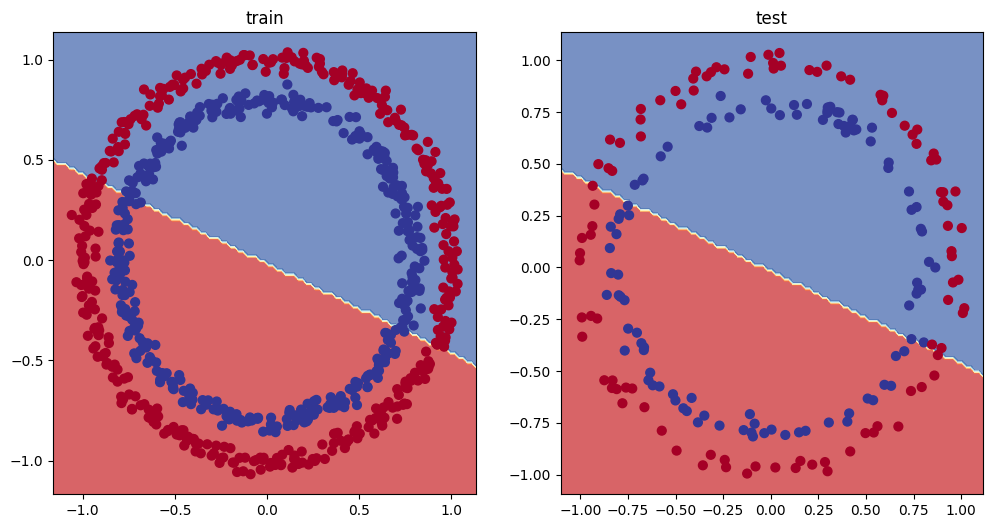

In [18]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("train")
plot_decision_boundary(model_v1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("test")
plot_decision_boundary(model_v1, X_test, y_test)

Again, the results are no better than a random guess.

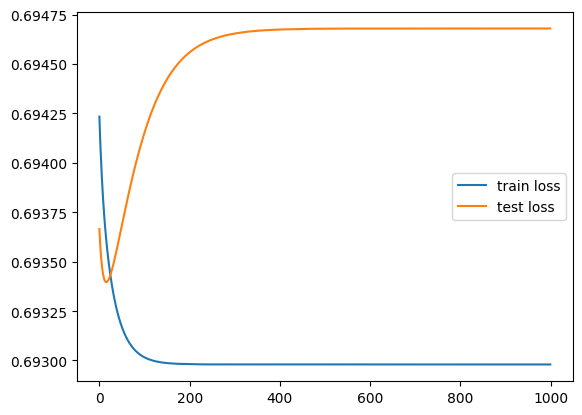

In [19]:
plt.plot(losses_v1[0], label="train loss")
plt.plot(losses_v1[1], label="test loss")
plt.legend()
plt.show()

The loss once again hangs around $ln(2)$.

Why is this occuring? Well, this is because we are not utilizing the real capabilities of neural networks just yet. Currently, both `V0` and `V1` are simply just overly complicated linear models.

Each layer is in the form

$$
y = Wx + b
$$

Stacking multiple layers without activations gives something akin to

$$
y = W_3(W_2(W_1x + b_1) + b_2) + b_3
$$

Which you could just rewrite as

$$
y = W'x + b'
$$

This linearity prevents the models from learning nonlinear patterns, which is a necessity to solving problems of this nature. For this purpose, activation functions are used.

## Model V2 (2 -> 64 -> 64 -> 10 -> 1, with ReLU)

`V2` is slightly beefed up from `V1` in terms of the number of layers and the neurons, but the most significant change is the addition of an activation function in between layers. In this case, the `ReLU` function is used, which is defined as

$$
\mathrm{ReLU}(x) = \max(0, x)
$$

This function introduces non-linearity to the network which theoretically should make it capable to learn to solve this type of problem.

In [20]:
class ModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(2, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 10),
        nn.ReLU(),
        nn.Linear(10, 1)
    )

  def forward(self, x):
    return self.model(x)

Training it for 500 epochs,

In [21]:
model_v2 = ModelV2()
losses_v2 = train_and_test(model_v2, epochs=500)

epoch 0 | train loss: 0.6951 | test loss: 0.6944 | train acc: 0.5000 | test acc: 0.5000
epoch 10 | train loss: 0.6929 | test loss: 0.6926 | train acc: 0.5000 | test acc: 0.5000
epoch 20 | train loss: 0.6916 | test loss: 0.6916 | train acc: 0.5500 | test acc: 0.5450
epoch 30 | train loss: 0.6908 | test loss: 0.6910 | train acc: 0.6150 | test acc: 0.6050
epoch 40 | train loss: 0.6902 | test loss: 0.6905 | train acc: 0.5425 | test acc: 0.5850
epoch 50 | train loss: 0.6896 | test loss: 0.6901 | train acc: 0.5350 | test acc: 0.5600
epoch 60 | train loss: 0.6891 | test loss: 0.6897 | train acc: 0.5363 | test acc: 0.5400
epoch 70 | train loss: 0.6885 | test loss: 0.6894 | train acc: 0.5375 | test acc: 0.5500
epoch 80 | train loss: 0.6878 | test loss: 0.6888 | train acc: 0.5413 | test acc: 0.5500
epoch 90 | train loss: 0.6872 | test loss: 0.6882 | train acc: 0.5387 | test acc: 0.5650
epoch 100 | train loss: 0.6865 | test loss: 0.6876 | train acc: 0.5463 | test acc: 0.5700
epoch 110 | train los

An immediate improvement is visible. The level of loss has significantly decreased, and the accuracy is also very high at about 91.37%. We can visualize the decision boundary to see it more clearly.

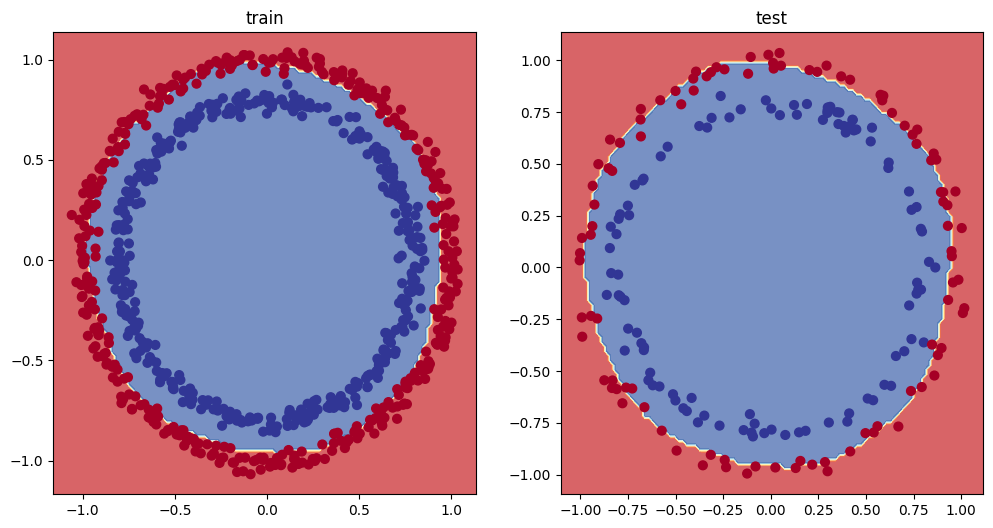

In [22]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("train")
plot_decision_boundary(model_v2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("test")
plot_decision_boundary(model_v2, X_test, y_test)

The network is finally capable of actually solving the problem to some extent, as it has successfully managed to divide the two sets of points in a fairly clean way, despite hugging a bit close to the outer points.

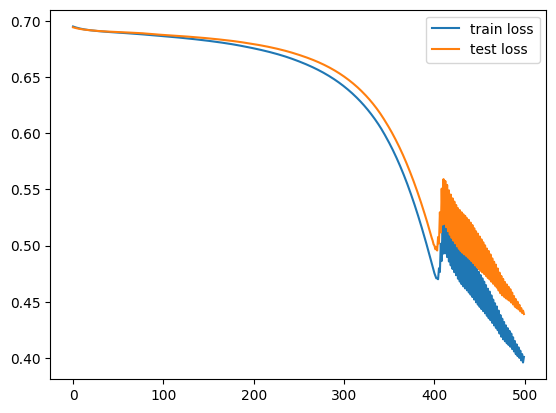

In [23]:
plt.plot(losses_v2[0], label="train loss")
plt.plot(losses_v2[1], label="test loss")
plt.legend()
plt.show()

The loss has decreased quite significantly despite an unstable spike and bounces starting around the 410 epoch mark.

### Using the Adam Optimizer

While the SGD optimizer is fairly effective for most tasks, it has the tendency to be quite slow and also unstable in steep regions, which was evident starting at around the 410 epoch mark in the earlier loss graph. The Adam optimizer can be used to fix these issues.

Adam (Adaptive Moment Estimation) is an optimizer that works by modifying the learning rate based on how past gradients have been changing. If the movement is consistently occuring in one direction, the step sizes can be increased, otherwise it slows the rate down for stability.

We will now test `V2` with the Adam optimizer.

In [24]:
def train_and_test_adam(model, epochs=100):
  model.to(device)
  # Replace default optimizer with Adam
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

  train_losses = []
  test_losses = []

  for epoch in range(epochs):
    model.train()
    y_logits = model(X_train).squeeze()
    loss = loss_fn(y_logits, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
      test_logits = model(X_test).squeeze()
      test_loss = loss_fn(test_logits, y_test)

    train_losses.append(loss.item())
    test_losses.append(test_loss.item())

    if epoch % 10 == 0:
      train_acc = accuracy_fn(y_train, y_logits)
      test_acc = accuracy_fn(y_test, test_logits)
      print(f"epoch {epoch} | train loss: {loss:.4f} | test loss: {test_loss:.4f} | train acc: {train_acc:.4f} | test acc: {test_acc:.4f}")

  return train_losses, test_losses

In [25]:
model_v2 = ModelV2()
losses_v2 = train_and_test_adam(model_v2, epochs=500)

epoch 0 | train loss: 0.6957 | test loss: 0.6921 | train acc: 0.5000 | test acc: 0.5000
epoch 10 | train loss: 0.5989 | test loss: 0.5936 | train acc: 0.9350 | test acc: 0.9550
epoch 20 | train loss: 0.3004 | test loss: 0.3033 | train acc: 0.9938 | test acc: 0.9950
epoch 30 | train loss: 0.0668 | test loss: 0.0849 | train acc: 1.0000 | test acc: 1.0000
epoch 40 | train loss: 0.0125 | test loss: 0.0247 | train acc: 1.0000 | test acc: 1.0000
epoch 50 | train loss: 0.0041 | test loss: 0.0125 | train acc: 1.0000 | test acc: 1.0000
epoch 60 | train loss: 0.0022 | test loss: 0.0086 | train acc: 1.0000 | test acc: 1.0000
epoch 70 | train loss: 0.0016 | test loss: 0.0068 | train acc: 1.0000 | test acc: 1.0000
epoch 80 | train loss: 0.0013 | test loss: 0.0060 | train acc: 1.0000 | test acc: 1.0000
epoch 90 | train loss: 0.0011 | test loss: 0.0054 | train acc: 1.0000 | test acc: 1.0000
epoch 100 | train loss: 0.0010 | test loss: 0.0050 | train acc: 1.0000 | test acc: 1.0000
epoch 110 | train los

An immediate improvement is visible; the loss has decreased significantly, and so has the accuracy, reaching close to a 100%.

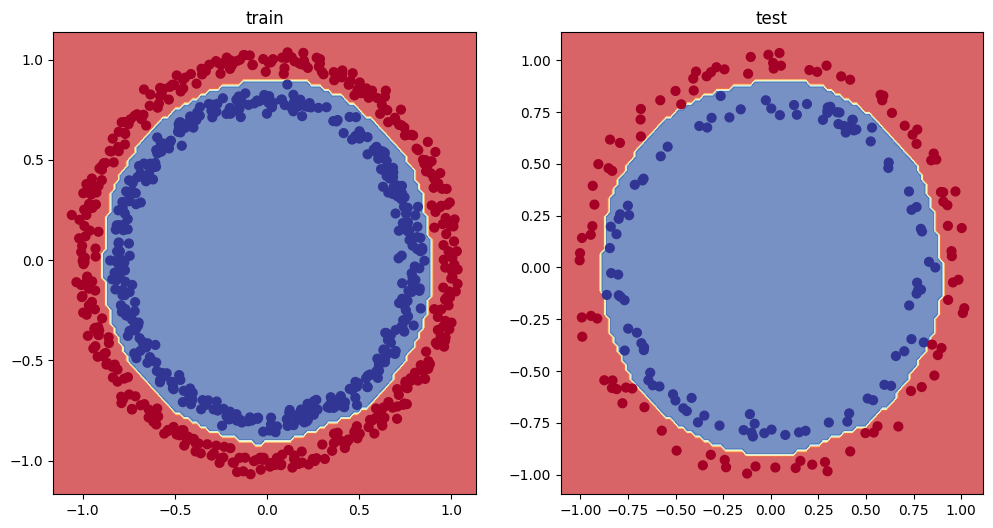

In [26]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("train")
plot_decision_boundary(model_v2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("test")
plot_decision_boundary(model_v2, X_test, y_test)

The decision boundary reflects the same.

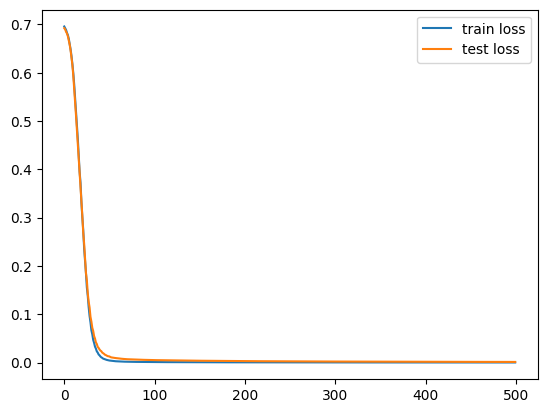

In [27]:
plt.plot(losses_v2[0], label="train loss")
plt.plot(losses_v2[1], label="test loss")
plt.legend()
plt.show()

The loss graph shows that the loss fell very quickly, reaching essentially zero before even a hundred epochs, showcasing the high performance levels of the Adam optimizer compared to SGD.

## Discussion

In this assignment, an introductory task was performed to learn about neural networks and how to work with them. This task, involving creating three separate networks and evaluating how each compares to the others, helped to provide a strong foundation for understanding the overall workflow of working with neural networks in `pytorch`.

Additionally, the first two networks being without activation functions helped to make the importance of them in neural networks clear; without an activation function, the levels of accuracy are far too low due to the network simply being a glorified linear equation. Using the activation function, in this case ReLU, provided an immediate and obvious improvement.

We also looked into optimizers and how a change in optimizer can change the performance of the whole network. This was illustrated by a use of the Adam optimizer for the final model, which significantly improved its performance and also increased the training speed by a vast level.

## Conclusion

Thus, in this assignment, we learnt about neural networks and how they can be implemented and analyzed using `pytorch` and other Python tools and libraries.